<a href="https://colab.research.google.com/github/RachitBansal/AppliancePower_TimeSeries/blob/master/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
####code to  upload the data and resample the data (day wise)
from sklearn.externals import joblib
from keras.layers import Dense ,LSTM
from keras.models import Sequential 
from sklearn.metrics import mean_absolute_error,mean_squared_error
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import pyplot
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from sklearn.metrics import r2_score as r2
import matplotlib.pyplot as plt
import tensorflow as tf

# import r2
# import mane

import keras.backend as K

import os

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
file_path = './drive/My Drive/final_resampled_data_5min.pkl'
data = joblib.load(file_path)

In [4]:
!ls

drive  sample_data


In [0]:
import keras.backend as K

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [0]:
# mane_loss = mane.mane

In [0]:
## Data Loading and Preprocessing:

In [204]:
print(data[:10,0])

[0.        0.        0.        0.        0.        0.        2.5121866
 0.        0.        0.       ]


In [0]:
# ### importing the data files

# # x_year = joblib.load("hour_resampled_data.pkl")
# # x_year = x_year.values
# # y_year = joblib.load("y_year_values.pkl")

# ###slicing the tiestamp from x_year
# # timestamps = data[:,0]

# #preparing data file for rnn
# # rnn_data  = x_year

# '''
# file = open(".dat")
# data = file.readlines()
# rnn_data=[]
# for i in data:
#     temp = i.split(" ")
#     rnn_data.append([int(x) for x in temp])
# '''

# ###changing the data file to dataframe 
# rnn_data = pd.DataFrame(rnn_data)
# final_data = rnn_data.values
# # rnn_data = rnn_data.set_index([0])
# # rnn_data.index = pd.to_datetime(rnn_data.index,unit = "s")

# # #resampling the data hourwise
# # resampler_day = rnn_data.resample("D")
# # day_resampled_data = resampler_day.sum()

# #saving the resampled file in the pickle format 
# #joblib.dump(day_resampled_data,"day_resampled_data.pkl")
# #changing the dataframe to array
# # final_day_array = np.asarray(day_resampled_data)

# #selecting the size of
# # print() 
# training_fraction = float(input("Enter the fraction of data to be sent to training :"))
# length = len(rnn_data)
# train_size = int(training_fraction*length)

# errors_saver = {}
            

In [6]:
training_fraction = float(input("Enter the fraction of data to be sent to training :"))
length = len(data)
train_size = int(training_fraction*length)

Enter the fraction of data to be sent to training :0.6


In [0]:
final_data = data/300

In [8]:
final_data.shape

(143136, 9)

In [0]:
def return_data(final_data, i):
    
    copy = final_data[:,i].reshape(-1,1)
    sc = MinMaxScaler()
    copy = sc.fit_transform(copy)
    
    #now we are going to divide into training and test set
    x_train = final_data[:train_size, i]
    y_train = final_data[:train_size, i]
    #x_train = x_train.reshape((-1,1,1))
    train_x = []
    train_y = []
    print("enter n steps : ")
    n_steps = int(input())
    list_i = 0
    print("Entering loop")
    print(x_train.shape)
    print(y_train.shape)
    k=0
    while k<x_train.shape[0]-n_steps-1:
        train = x_train[k:k+n_steps]
        train_x.append([float(x) for x in train])
        train_y.append(y_train[k+n_steps])
        k= k+1
    
    train_x = np.asarray(train_x)
    train_y = np.asarray(train_y)    
    train_x = train_x.reshape((-1,n_steps,1))
    train_y = train_y.reshape((-1,1,1))
    
    x_test = final_data[train_size:, i]
    y_test = final_data[train_size:, i]
    #x_test = x_test.reshape((-1,1,1))
    test_x = []
    test_y = []
    k=0
    while k < x_test.shape[0]-n_steps-1:
        test= x_test[k:k+n_steps]
        test_x.append([x for x in test])
        test_y.append(y_test[k+n_steps])
        k = k+1
    test_x = np.asarray(test_x)
    test_y = np.asarray(test_y)
    
    test_x = test_x.reshape((-1,n_steps,1))
    test_y = test_y.reshape((-1,1,1))
    
    '''
    regressor = Sequential()
    regressor.add(LSTM(units = 10,activation = "relu",input_shape= (None,1)))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = "adam",loss = "mean_squared_error",metrics = ["accuracy"])
    regressor.fit(train_x,train_y,epochs = 100 ,batch_size = 7,validation_split = 0.1)
    '''
    # print("Enter 1 if you want to process next equipment and 0 if not :")
    # decision = int(input())
    # if decision==1:
    #     pass
    # else:
    #     break

    return train_x, test_x, train_y, test_y

In [10]:
equipment = int(input("Equipment: "))
train_x, test_x, train_y, test_y = return_data(final_data, equipment-1)

Equipment: 1
enter n steps : 
128
Entering loop
(85881,)
(85881,)


In [11]:
print(np.mean(train_x.reshape(-1)), np.mean(train_y.reshape(-1)))
print(np.mean(test_x.reshape(-1)), np.mean(test_y.reshape(-1)))

113.37644329290737 113.36412124362883
122.29748246598542 122.4781718584501


In [24]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(85752, 128, 1) (85752, 1, 1) (57126, 128, 1) (57126, 1, 1)


## Ensemble:

### Sub-Models:
- Using 3 CNN_LSTMs 

In [244]:
def fit_cnn_lstm(x_train, y_train):
    
    n_timesteps, n_features = x_train.shape[1], x_train.shape[2]
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(1))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.summary()
    model.compile(loss='mse', optimizer='adam',metrics = ["accuracy"])

    model.fit(x_train, y_train, epochs=10, batch_size=128, verbose = 1)
    
    return model

# os.makedirs('ensemble')

# fit and save models
n_members = 3
for i in range(n_members):
    model = fit_cnn_lstm(train_x, train_y)
    filename = './drive/My Drive/model_' + str(i + 1) + '.h5'
    model.save(filename)
    print('>>> Saved %s' % filename)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_47 (Conv1D)           (None, 126, 64)           256       
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 124, 64)           12352     
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 62, 64)            0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 3968)              0         
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 1, 3968)           0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 1, 200)            3335200   
_________________________________________________________________
time_distributed_47 (TimeDis (None, 1, 100)          

KeyboardInterrupt: ignored

In [13]:
from keras.models import load_model

def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = './drive/My Drive/model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>>> loaded %s' % filename)
    return all_models

n_members = 3
members = load_all_models(n_members)
print('Loaded %d models' % len(members))












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


>>> loaded ./drive/My Drive/model_1.h5
>>> loaded ./drive/My Drive/model_2.h5
>>> loaded ./drive/My Drive/model_3.h5
Loaded 3 models


In [0]:
#### Evaluating the 3 CNN_LSTMS Individually

In [258]:
for model in members:
    # testy_enc = to_categorical(testy)
    _, acc = model.evaluate(test_x, test_y, verbose=0)
    print('Model Accuracy: %.3f' % acc)

Model Accuracy: 0.068
Model Accuracy: 0.088
Model Accuracy: 0.054


In [0]:
preds = []
for j in range(n_members):
  model_preds = []
  for i in range(1000):
      model_preds.append(members[j].predict(test_x[i].reshape(1,-1,1))[0][0][0])
  preds.append(model_preds)

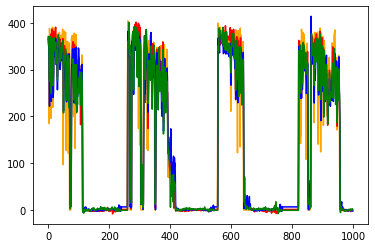

In [270]:
plt.plot(test_y[:1000].reshape(-1), c = 'orange')
list_colrs = ['red', 'blue', 'green']
for j in range(n_members):
  plt.plot(preds[j], c = list_colrs[j])
plt.show()

### Creating Dataset to go into XGBoost
- Outputs from the 3 sub models flow into XGBoost

In [0]:
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(inputX, verbose=0)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = np.dstack((stackX, yhat))

    # flatten [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

In [0]:
from xgboost import XGBClassifier
import xgboost

In [0]:
def fit_stacked_model(members, inputX, inputy, n_est=45, alpha = 10):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = xgboost.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = alpha, n_estimators = n_est)
    model.fit(stackedX, inputy)
    return model

In [71]:
model = fit_stacked_model(members, test_x, test_y)

[20:06:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Compiling Ensemble Model

In [0]:
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

### Evaluating

In [0]:
# yhat = stacked_prediction(members, model, test_x)
# acc = r2_score(testy, yhat)
# print('--> Stacked Test Accuracy: %.3f' % acc)

In [0]:
# for i in range(1000):
#   print(test_x[i].reshape(1,-1,1).shape)

[20:11:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


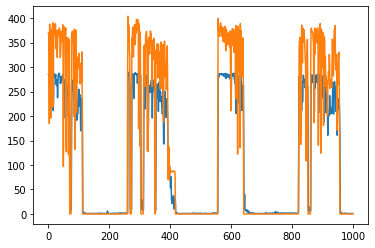

[20:11:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


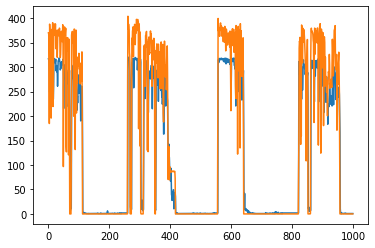

[20:12:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


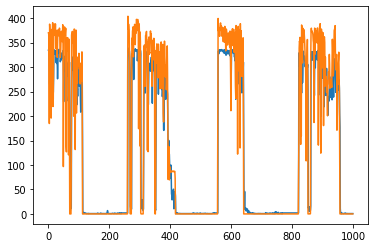

[20:12:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


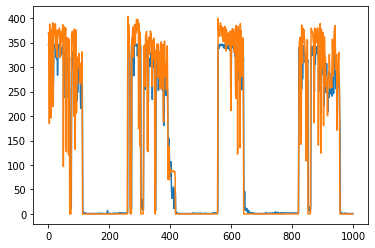

[20:13:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


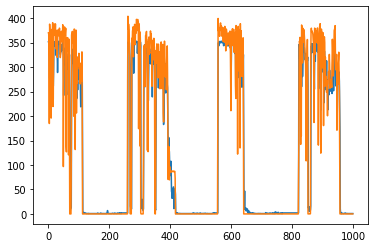

In [79]:
n_e_list = [15,20,25,30,35]           # number of estimators going into xgboost
for n_e in n_e_list:
  model = fit_stacked_model(members, test_x, test_y, n_e)  
  preds = stacked_prediction(members, model, test_x[:1000])
  plt.plot(preds)
  plt.plot(test_y[:1000].reshape(-1))
  plt.show()

[20:14:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


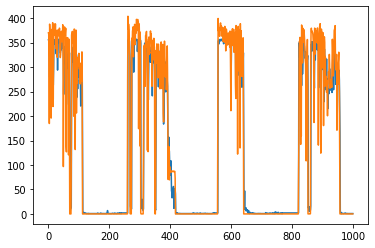

In [80]:
model = fit_stacked_model(members, test_x, test_y, 40)  
preds = stacked_prediction(members, model, test_x[:1000])
plt.plot(preds)
plt.plot(test_y[:1000].reshape(-1))
plt.show()

[20:15:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


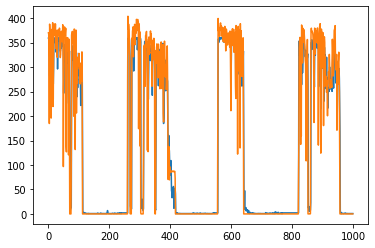

In [81]:
model = fit_stacked_model(members, test_x, test_y, 50)  
preds = stacked_prediction(members, model, test_x[:1000])
plt.plot(preds)
plt.plot(test_y[:1000].reshape(-1))
plt.show()

[20:23:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


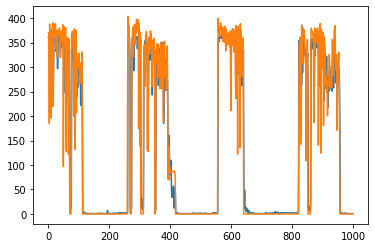

In [82]:
model = fit_stacked_model(members, test_x, test_y, 60)  
preds = stacked_prediction(members, model, test_x[:1000])
plt.plot(preds)
plt.plot(test_y[:1000].reshape(-1))
plt.show()

[20:26:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


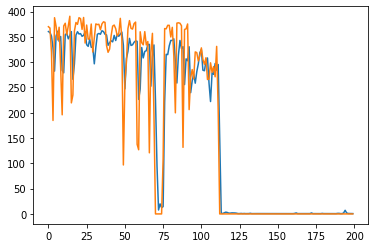

In [84]:
model = fit_stacked_model(members, test_x, test_y, 60)  
preds = stacked_prediction(members, model, test_x[:200])
plt.plot(preds)
plt.plot(test_y[:200].reshape(-1))
plt.show()

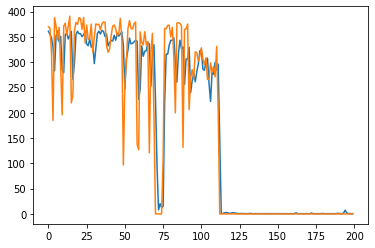

In [94]:
# model = fit_stacked_model(members, test_x, test_y, 60)  
preds = stacked_prediction(members, model, test_x[:200])
plt.plot(preds)
plt.plot(test_y[:200].reshape(-1))
plt.show()

In [93]:
model = fit_stacked_model(members, test_x, test_y, 100, 20)  

[20:34:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


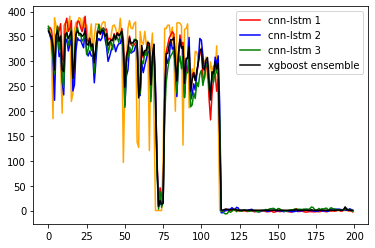

In [96]:
preds = []
for j in range(n_members):
  model_preds = []
  for i in range(200):
      model_preds.append(members[j].predict(test_x[i].reshape(1,-1,1))[0][0][0])
  preds.append(model_preds)
e_preds = stacked_prediction(members, model, test_x[:200])
preds.append(e_preds)

plt.plot(test_y[:200].reshape(-1), c = 'orange')
list_colrs = ['red', 'blue', 'green', 'black']
labels = ['cnn-lstm 1', 'cnn-lstm 2', 'cnn-lstm 3', 'xgboost ensemble']
for j in range(n_members+1):
  plt.plot(preds[j], c = list_colrs[j], label=labels[j])
  plt.legend()
plt.show()

In [0]:
# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(28,28)))
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(RepeatVector(1))
# model.add(LSTM(200, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(100, activation='relu')))
# model.add(TimeDistributed(Dense(1)))
# model.compile(loss= mane_loss, optimizer='adam',metrics = ["accuracy", r2])
# # fit network
# history = model.fit(x_train, y_train, epochs=30, batch_size=5, validation_split = 0.1)

# pyplot.plot(history.history['loss'])
# pyplot.plot(history.history['val_loss'])
# pyplot.title('model train vs validation loss')
# pyplot.ylabel('loss')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'validation'], loc='upper right')
# pyplot.show()

In [0]:
    y_pred = model.predict(test_x)
    y_pred = y_pred.reshape((-1,1))
    test_y  = test_y.reshape((-1,1))
    mse = mean_squared_error(test_y,y_pred)
    rms = sqrt(mse)
    mae = mean_absolute_error(test_y,y_pred)
    print("mean_squared_error : ",mse)
    print("root_mean_squared_error : ",rms)
    print("mean_absolute_error : ",mae)
    #errors_saver["errors_equipment{}".format(i+1)] = {"mean_squared_error":mse,"mean_absolute_error":mae,"root_mean_squared_error":rms}
    y_pred = sc.inverse_transform(y_pred)
    test_y = sc.inverse_transform(test_y)


    l=0
    while l<len(test_y)-7:
        plt.scatter([1,2,3,4,5,6,7],y_pred[l:l+7,:],color  = "cyan",label = "predicted_day")
        #plt.savefig("equipment2_day(prediction){}".format(i//288))
        #plt.legend()
        #plt.show()
        plt.scatter([1,2,3,4,5,6,7],test_y[l:l+7,:],color = "blue",label = "real_values")
        plt.legend()
        plt.xlabel("day")
        plt.ylabel("power_consumption")
        #plt.savefig("equipment9_day{}.png".format(i//24))
        plt.show()
        l = l+7